# Intersecting rasters with modelgrids using FloPy's Raster class

A Raster class was developed as a wrapper that leverages RasterIO and SciPy built in methods for easy raster intersections and cropping. 

This notebook will show some of the basic functionality of the `Raster` class with structured and unstructured model grid examples.

The `Raster` class accepts Tiff and GeoTiff, ASCII Grid (ESRI ASCII), and Erdas Imagine .img files. 

Ideally this can be used to easily snap DEM rasters, PET, PPT, recharge and other rasters to a modflow grid for further processing and/or to apply as fluxes and boundary conditions to a MODFLOW model

In [1]:
import os
import sys
import time
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import shapely
import shapefile

try:
    import flopy
    from flopy.utils import Raster
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy
    from flopy.utils import Raster
    
print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('pandas version: {}'.format(pd.__version__))
print('shapely version: {}'.format(shapely.__version__))
print('flopy version: {}'.format(flopy.__version__))  

3.7.7 (default, Mar 26 2020, 10:32:53) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
numpy version: 1.19.2
matplotlib version: 3.3.0
pandas version: 1.0.5
shapely version: 1.7.1
flopy version: 3.3.2


In [2]:
if not os.path.exists("temp"):
    os.mkdir("temp");

### Raster files can be loaded using the `Raster.load` method

In [3]:
raster_ws = os.path.join("..", "data", "options", "dem")
raster_name = "dem.img"

rio = Raster.load(os.path.join(raster_ws, raster_name))

The bands within the raster can be viewed by calling the parameter `bands`; there is only one band in this raster

In [4]:
rio.bands

(1,)

Using the built in `.plot` method, we can take a look at the DEM raster data before we start manipulating it

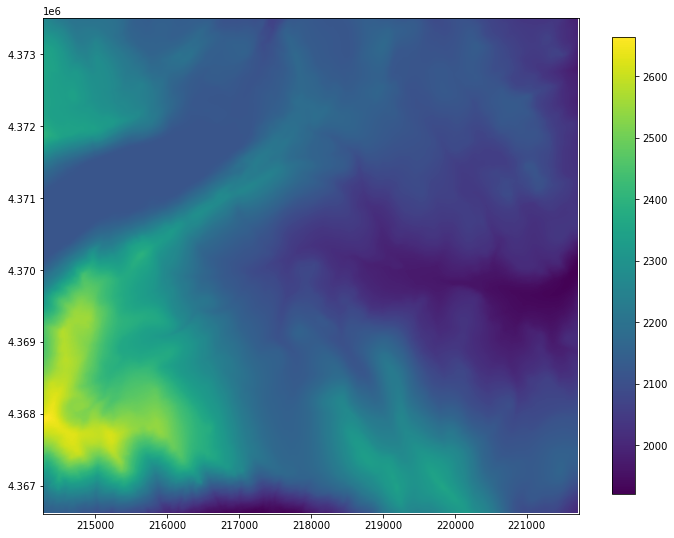

In [5]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

ax = rio.plot(ax=ax)
plt.colorbar(ax.images[0], shrink=0.7);

## Intersecting and resampling a data using the FloPy ModelGrid

### Structured Grid Example

The structured grid example uses the DIS file from the GSFLOW Sagehen example problem to create a modelgrid

   loading iuzfbnd array...
   loading vks array...
   loading eps array...
   loading thts array...
stress period 1:
   loading finf array...
stress period 2:


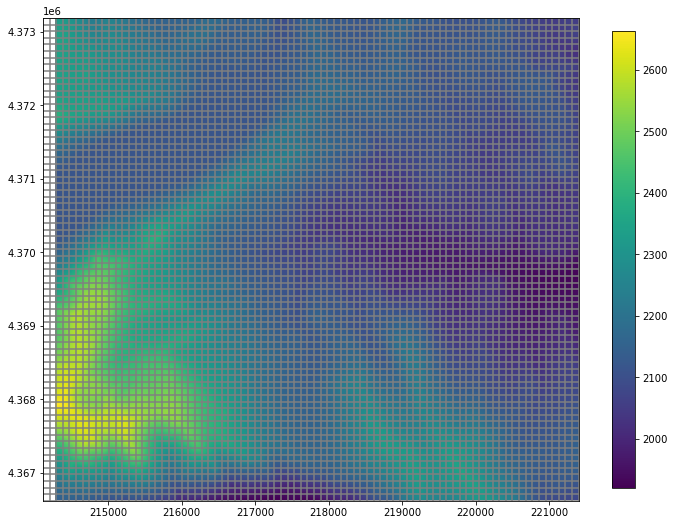

In [6]:
model_ws = os.path.join("..", "data", "options", "sagehen")
ml = flopy.modflow.Modflow.load("sagehen.nam", version="mfnwt",
                                model_ws=model_ws)

xoff = 214110
yoff = 4366620
ml.modelgrid.set_coord_info(xoff=xoff, yoff=yoff)


fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

ax = rio.plot(ax=ax)
plt.colorbar(ax.images[0], shrink=0.7)
pmv = flopy.plot.PlotMapView(modelgrid=ml.modelgrid)
pmv.plot_grid(ax=ax);

Once a modelgrid has been loaded, the `resample_to_grid()` method can be used to re-sample the data to an array consistent with the model grid.  

Inputs to `resample_to_grid()` include:

+ `xc` : the xcenters of the model grid  
+ `yc` : the ycenters of the model grid  
+ `band` : raster band to resample  
+ `method` : resampling method, options include:  
    - `"nearest"` for nearest neighbor   
    - `"linear"` for bilinear sampling  
    - `"cubic"` for bicubic sampling  
    
__Nearest neighbor is the quickest method for resampling and bi-cubic is the slowest method.__  
Note: Bottlenecks in sampling time are due to raster resolution, not number of grid cells

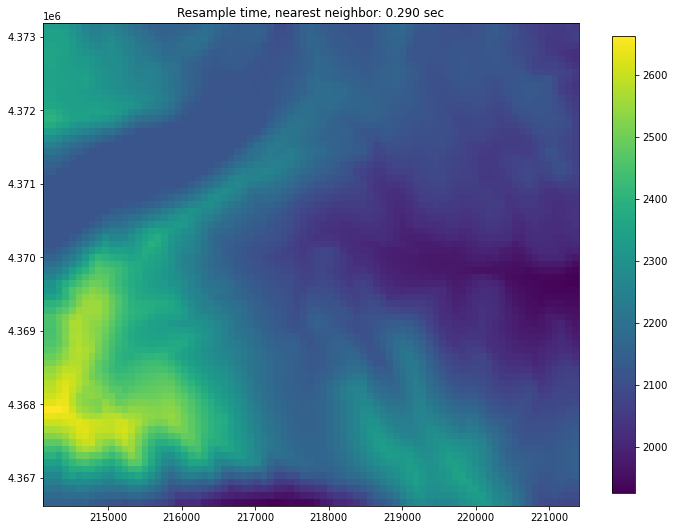

In [7]:
t0 = time.time()
dem_data = rio.resample_to_grid(ml.modelgrid.xcellcenters,
                                ml.modelgrid.ycellcenters,
                                band=rio.bands[0],
                                method="nearest")
resample_time = time.time() - t0
# print("Resample time, nearest neighbor: {:.3f} sec".format(time.time() - t0))

# now to visualize using flopy and matplotlib
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

pmv = flopy.plot.PlotMapView(modelgrid=ml.modelgrid, ax=ax)
ax = pmv.plot_array(dem_data, masked_values=rio.nodatavals)
plt.title("Resample time, nearest neighbor: {:.3f} sec".format(resample_time))
plt.colorbar(ax, shrink=0.7);

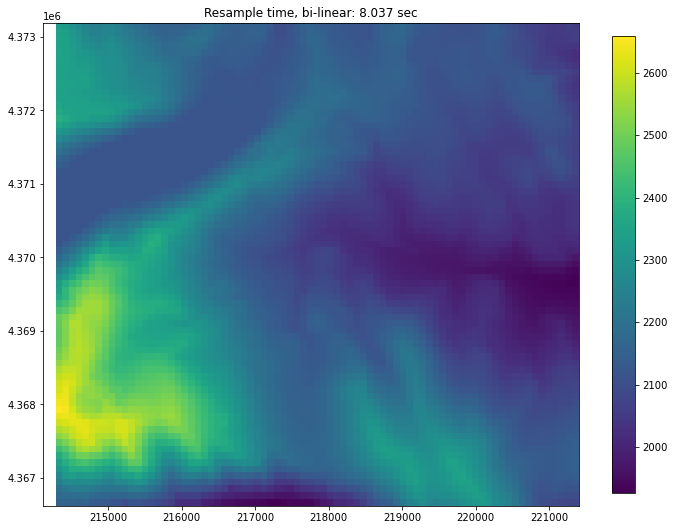

In [8]:
t0 = time.time()
dem_data = rio.resample_to_grid(ml.modelgrid.xcellcenters,
                                ml.modelgrid.ycellcenters,
                                band=rio.bands[0],
                                method="linear")
resample_time = time.time() - t0

# now to visualize using flopy and matplotlib
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

pmv = flopy.plot.PlotMapView(modelgrid=ml.modelgrid, ax=ax)
ax = pmv.plot_array(dem_data, masked_values=rio.nodatavals)
plt.title("Resample time, bi-linear: {:.3f} sec".format(resample_time))
plt.colorbar(ax, shrink=0.7);

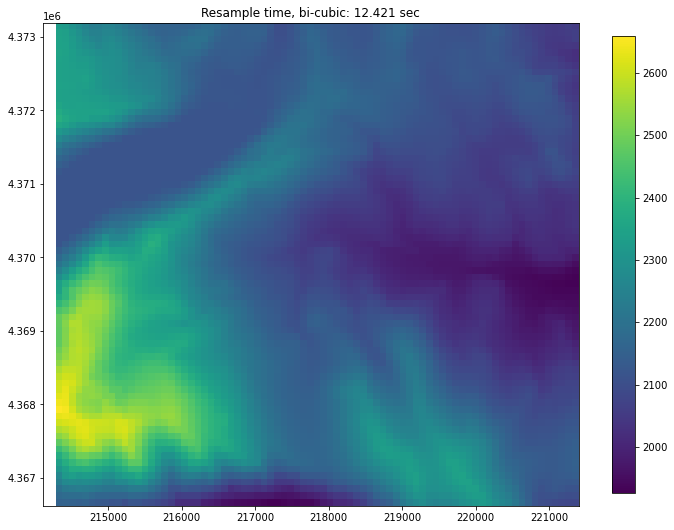

In [9]:
t0 = time.time()
dem_data = rio.resample_to_grid(ml.modelgrid.xcellcenters,
                                ml.modelgrid.ycellcenters,
                                band=rio.bands[0],
                                method="cubic")
resample_time = time.time() - t0

# now to visualize using flopy and matplotlib
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

pmv = flopy.plot.PlotMapView(modelgrid=ml.modelgrid, ax=ax)
ax = pmv.plot_array(dem_data, masked_values=rio.nodatavals)
plt.title("Resample time, bi-cubic: {:.3f} sec".format(resample_time))
plt.colorbar(ax, shrink=0.7);

## Vertex and Unstructured grid example

The user can also use either a vertex grid or an unstructured grid and resample raster data to it using the same `resample_to_grid()` method

Here is an example of building a triangular mesh and creating an unstructured grid instance to use for Raster resampling

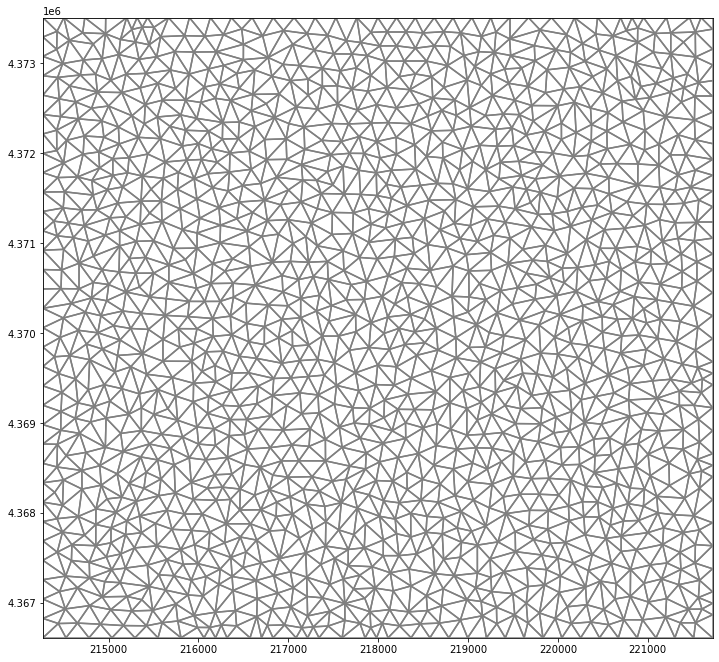

In [10]:
from flopy.utils.triangle import Triangle

maximum_area = 30000.# 30000.

extent = rio.bounds
domainpoly = [(extent[0], extent[2]),
              (extent[1], extent[2]),
              (extent[1], extent[3]),
              (extent[0], extent[3])]

tri = Triangle(maximum_area=maximum_area, angle=30, model_ws="temp")

tri.add_polygon(domainpoly)
tri.build(verbose=False)
xc, yc = tri.get_xcyc().T
ncpl = np.array([len(tri.iverts)])

# todo: update Unstructured grid ncpl to accept a list, int, or np.array...
mg_unstruct = flopy.discretization.UnstructuredGrid(vertices=tri.verts, 
                                                    iverts=tri.iverts,
                                                    ncpl=ncpl,
                                                    xcenters=xc,
                                                    ycenters=yc,
                                                    layered=False)
# now to visualize using matplotlib
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

pmv = flopy.plot.PlotMapView(modelgrid=mg_unstruct, ax=ax)
pmv.plot_grid();

Once a grid object is created, the raster can be resampled to the grid using the same `resample_to_grid()` method as the structured grid example

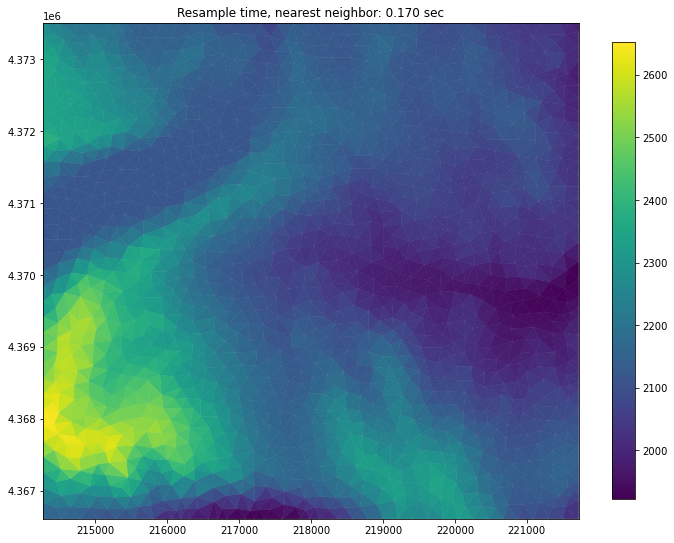

In [11]:
t0 = time.time()
dem_data = rio.resample_to_grid(mg_unstruct.xcellcenters,
                                mg_unstruct.ycellcenters,
                                band=rio.bands[0],
                                method="nearest")

resample_time = time.time() - t0

# now to visualize using flopy and matplotlib
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

pmv = flopy.plot.PlotMapView(modelgrid=mg_unstruct, ax=ax)
ax = pmv.plot_array(dem_data, masked_values=rio.nodatavals, cmap="viridis")
plt.title("Resample time, nearest neighbor: {:.3f} sec".format(resample_time))
plt.colorbar(ax, shrink=0.7);

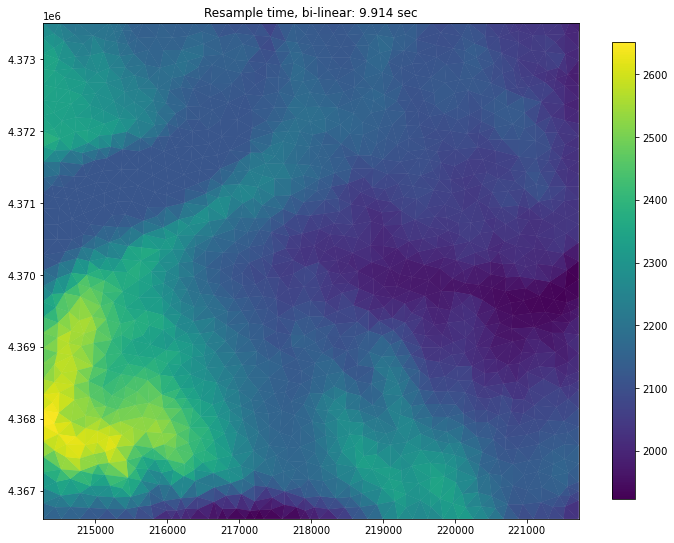

In [12]:
t0 = time.time()
dem_data = rio.resample_to_grid(mg_unstruct.xcellcenters,
                                mg_unstruct.ycellcenters,
                                band=rio.bands[0],
                                method="linear")

resample_time = time.time() - t0

# now to visualize using flopy and matplotlib
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

pmv = flopy.plot.PlotMapView(modelgrid=mg_unstruct, ax=ax)
ax = pmv.plot_array(dem_data, masked_values=rio.nodatavals, cmap="viridis")
plt.title("Resample time, bi-linear: {:.3f} sec".format(resample_time))
plt.colorbar(ax, shrink=0.7);

__Note: bi-cubic sampling does not work well with triangular meshes and is not recommended for unstructured grids__

# Sampling points, Cropping, and performing intersections using raster data

The `Raster` class contains useful methods for sampling single points, cross sections, cropping and performing intersections.

The `sample_point()` method can be used to sample a single raster value or to sample a cross section

The `sample_polygon()` method can be used to sample all raster values within an arbitrary polygone

The `crop()` method allows the user to crop the raster in-place. This method can also be used to perform intersections.

The `crop()` and `sample_polygon()` methods apply a modified binary ray casting algorithm for extremely fast intersections. The raster data that's used for this example contains over 500,000 points. For each intersection every point must be segmented as inside or outside of an arbitratry polygon.

### Sampling points or a cross section from the raster

The user can also sample from a points within the raster using the `sample_point()` method.

This can be used to create simple cross sections of data, such as an elevation profile

,easting,northing,elevation
0,214111,4366621,2149.143311
1,214211,4366721,2165.882812
2,214311,4366821,2198.365234
3,214411,4366921,2260.733643
4,214511,4367021,2335.735596


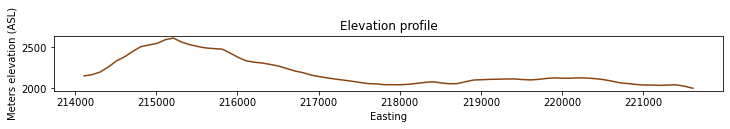

In [13]:
d = {"easting": [],
     "northing": [],
     "elevation": []}

for adj in range(1, 10000, 100):
    easting = xoff + adj
    northing = yoff + adj
    val = rio.sample_point(xoff+adj, yoff+adj, band=1)
    d["easting"].append(easting)
    d["northing"].append(northing)
    d["elevation"].append(val)
    
df = pd.DataFrame(d)

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

ax.plot(df.easting.values, df.elevation.values, color="saddlebrown")
ax.set_ylabel("Meters elevation (ASL)")
ax.set_xlabel("Easting")
ax.set_title("Elevation profile")

df.head()

### Sampling all points within a polygon in the raster

The user can also sample all points within an arbitrary polygon within the raster using the `sample_polygon()` method.

The `sample_polygon()` method returns an unordered array of raster values that can be used to perform statical analysis on a chunk of the raster data

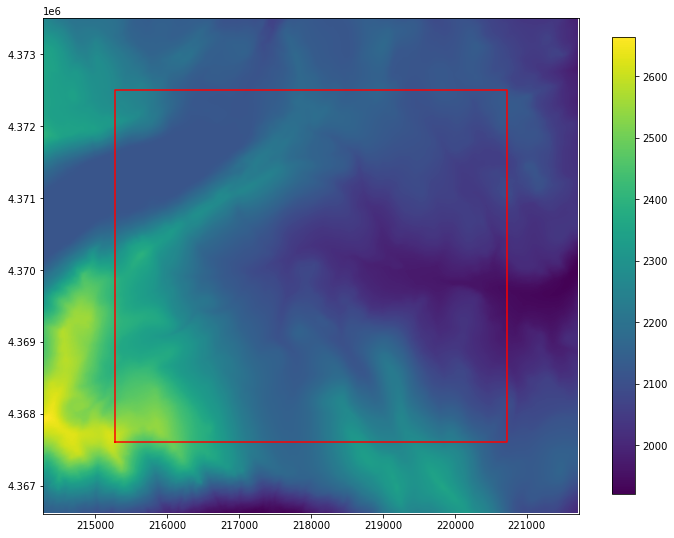

In [14]:
x0, x1, y0, y1 = rio.bounds

# let's create an a square to use for sampling and cropping
x0 += 1000
y0 += 1000
x1 -= 1000
y1 -= 1000

shape = np.array([(x0, y0), (x0, y1), (x1, y1), (x1, y0), (x0, y0)])

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

ax = rio.plot(ax=ax)
ax.plot(shape.T[0], shape.T[1], "r-")
plt.colorbar(ax.images[0], shrink=0.7);

In [15]:
data = rio.sample_polygon(shape, band=rio.bands[0])

mean = np.mean(data)
dmin = np.min(data)
dmax = np.max(data)
stdv = np.std(data)

s = "Minimum elevation: {:.2f}\nMaximum elevation: {:.2f}\nMean elevation: {:.2f}\nStandard deviation: {:.2f}"
print(s.format(dmin, dmax, mean, stdv))

Minimum elevation: 1942.17
Maximum elevation: 2608.56
Mean elevation: 2151.67
Standard deviation: 113.60


### Cropping and resampling to a modelgrid

The `crop()` method can accept a `list` or `np.array` of vertices, a shapely `Polygon` object, or a GeoJSON dictionary

The crop can also be inverted, using `invert=True`

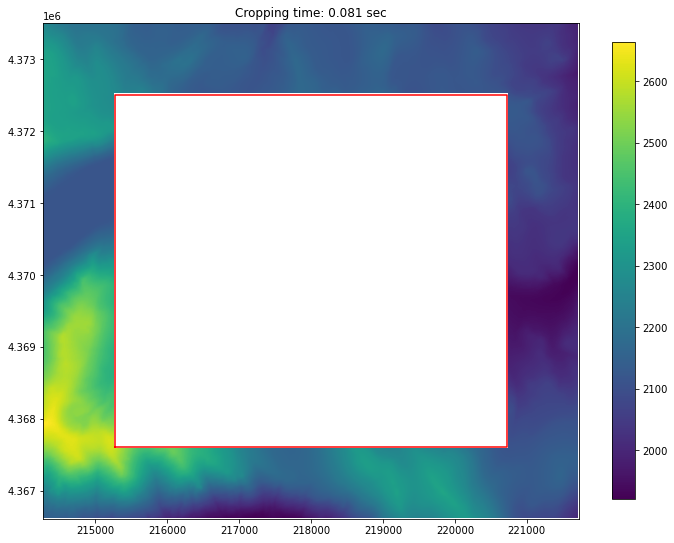

In [16]:
t0 = time.time()
rio.crop(shape, invert=True)
crop_time = time.time() - t0


fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

ax = rio.plot(ax=ax)
ax.plot(shape.T[0], shape.T[1], "r-")
plt.title("Cropping time: {:.3f} sec".format(crop_time))
plt.colorbar(ax.images[0], shrink=0.7);

And then this can be re-sampled to a ModelGrid Object

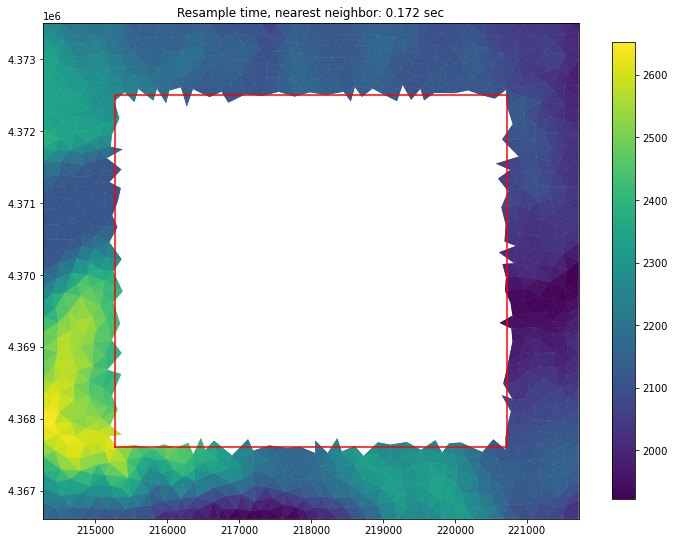

In [17]:
t0 = time.time()
dem_data = rio.resample_to_grid(mg_unstruct.xcellcenters,
                                mg_unstruct.ycellcenters,
                                band=rio.bands[0],
                                method="nearest")

resample_time = time.time() - t0

# now to visualize using flopy and matplotlib
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

pmv = flopy.plot.PlotMapView(modelgrid=mg_unstruct, ax=ax)
ax = pmv.plot_array(dem_data, masked_values=rio.nodatavals, cmap="viridis")
plt.plot(shape.T[0], shape.T[1], "r-")
plt.title("Resample time, nearest neighbor: {:.3f} sec".format(resample_time))
plt.colorbar(ax, shrink=0.7);

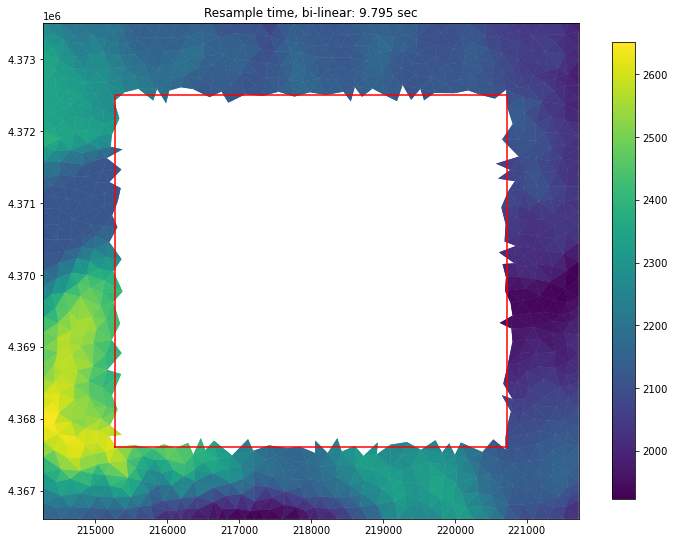

In [18]:
t0 = time.time()
dem_data = rio.resample_to_grid(mg_unstruct.xcellcenters,
                                mg_unstruct.ycellcenters,
                                band=rio.bands[0],
                                method="linear")

resample_time = time.time() - t0

# now to visualize using flopy and matplotlib
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

pmv = flopy.plot.PlotMapView(modelgrid=mg_unstruct, ax=ax)
ax = pmv.plot_array(dem_data, masked_values=rio.nodatavals, cmap="viridis")
plt.plot(shape.T[0], shape.T[1], "r-")
plt.title("Resample time, bi-linear: {:.3f} sec".format(resample_time))
plt.colorbar(ax, shrink=0.7);

### Here's an example of loading an arbitrary shape that will be used to define a model boundary

In the example pyshp and shapely are used to get geometry information and then we create a top array and an ibound array using that geometry information

First let's reload the raster (since operations are done in-place) and then load our shapefile data

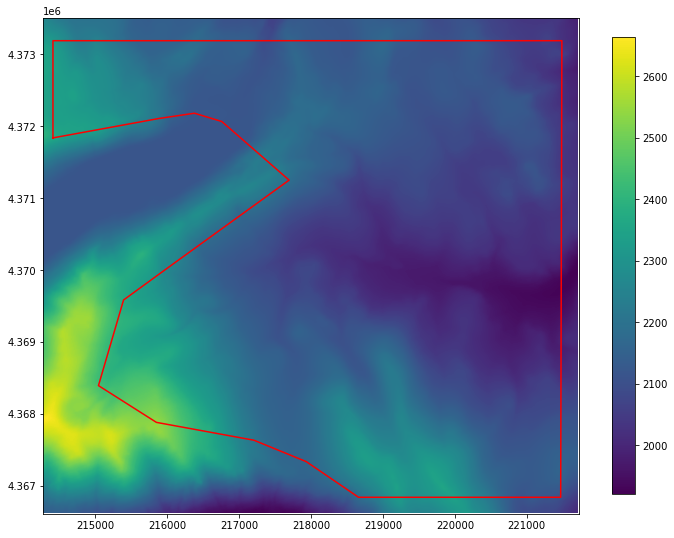

In [19]:
rio = Raster.load(os.path.join(raster_ws, raster_name))

shp_name = os.path.join(raster_ws, "model_boundary.shp")

# read in the shapefile
sf = shapefile.Reader(shp_name)
shapes = sf.shapes()

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

ax = rio.plot(ax=ax)

# plot the shapes for visualization
for shp in shapes:
    shp = np.array(shp.points).T
    plt.plot(shp[0], shp[1], "r-")
plt.colorbar(ax.images[0], shrink=0.7);

Now we can apply an intersection using the point data directly from the shapefile class

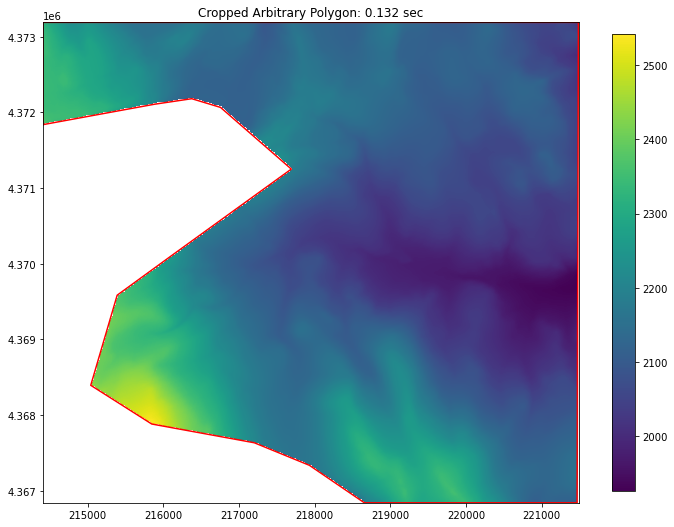

In [20]:
polygon = shapes[0].points

t0 = time.time()
rio.crop(polygon)
crop_time = time.time() - t0

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

ax = rio.plot(ax=ax)

shape = np.array(polygon).T
plt.plot(shape[0], shape[1], "r-")
plt.title("Cropped Arbitrary Polygon: {:.3f} sec".format(crop_time))
plt.colorbar(ax.images[0], shrink=0.7);

Now the data can be re-sampled to the modelgrid

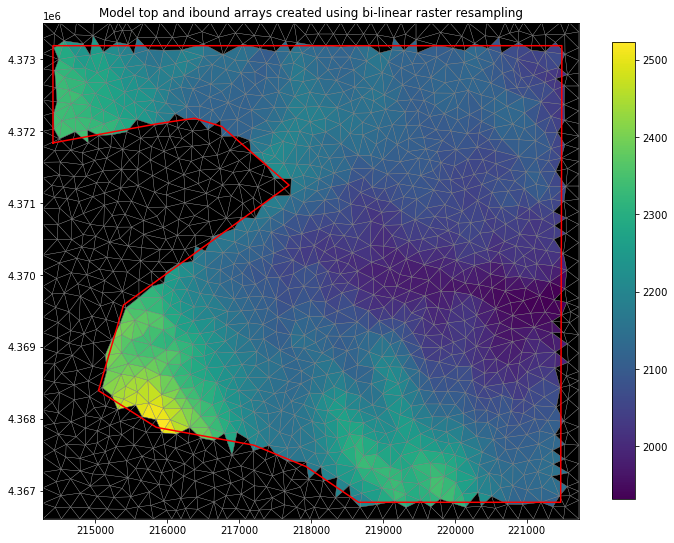

In [21]:
top = rio.resample_to_grid(mg_unstruct.xcellcenters,
                           mg_unstruct.ycellcenters,
                           band=rio.bands[0],
                           method="linear")

# apply a "realistic" nodataval to top cells outside the model domain
for val in rio.nodatavals:
    top[top == val] = 3500    

# create an ibound array
ibound = np.ones(top.shape, dtype=int)
ibound[top == 3500] = 0

# now to visualize using flopy and matplotlib
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

pmv = flopy.plot.PlotMapView(modelgrid=mg_unstruct, ax=ax)
ax = pmv.plot_array(top, masked_values=[3500,], cmap="viridis")
ib = pmv.plot_ibound(ibound)
pmv.plot_grid(linewidth=0.3)
plt.plot(shape[0], shape[1], "r-")
plt.title("Model top and ibound arrays created using bi-linear raster resampling")
plt.colorbar(ax, shrink=0.7);

The `ibound` array and the `top` array can be used to build or edit the BAS and DIS file objects in FloPy

## Future development

Potential features that draw on this functionality could include:  
+ intersection with multiple polygons  
+ flow accumulation to develop SFR networks
+ streambed topology from raster layers
+ intersection with layers of derived parameters based on multiple raster bands